# Model for Character Recognition

#### Datasets Used for the model training:
> Open source datasets such as MNIST and Kaggle’s mathematical symbols are used for training the model.
1. (0-9) : Open source MNIST digits dataset of size (28*28)
2. ( ‘(’ , ‘)’, ‘-’, ‘+’, ‘*’ ): Kaggle Handwritten Mathematical Symbols Dataset of size (45 * 45)
3. I have around 125k pictures for each of these 15 character classes.

#### Preprocessing of symbols image was performed to match MNIST digits images specifiction :
>In the MNIST dataset, there are several preprocessing stages as follows.
 - 500 different people provided 128 * 128 pixel handwritten numbers.
 - A Gaussian filter is used to the image to soften the edges.
 - The digit is then placed and centered within a square image while maintaining the aspect ratio.
 - The image is then downscaled to 28 x 28 pixels using bi-cubic interpolation.

Symbols data from kaggle's data set are pre-processed in the same way as MNIST digits are before training to match its image specifications. If the data sets used have different dimensions, thickness, and line width, pre-processing becomes a must,Since it  will be harder for the deep learning model to identify patterns in the data. The use of pre-processing will help to reduce digit and symbol variances.

[Source: MNIST](http://yann.lecun.com/exdb/mnist/)


![MNIST](C:\Users\Abhishek\Desktop\final_project\Autograding-handwritten-mathematical-worksheets-master\project_images\mnist.png)



In [8]:

#display.Image(r"C:\Users\Abhishek\Desktop\final_project\Autograding-handwritten-mathematical-worksheets-master\project_images\mnist.png")

#### Importing required packages

In [11]:
import os # Installed
import cv2 # Installed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import keras
import math
from scipy import ndimage
#from rasa_nlu import config
import tensorflow as tf
from keras.utils.vis_utils import plot_model
#!pip install graphviz
import pydot
import graphviz
from IPython import display

#### Setting directory where the images of each class will be processed and saved.

In [12]:
train_dir = r"C:\Users\Abhishek\Desktop\final_project\Autograding-handwritten-mathematical-worksheets-master\data_collection\mnist_kaggles_symbols"

#### At the moment the data is in a folder as raw JPEG files, so to get the data into the network I need to:

1. Read the images and encode them into grayscale grid of pixels
2. Convert it into grayscale numerical tensors of dimensions (1,28,28.)
3. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (normalization)

The keras package has utilities to take care of these steps automatically, implementing them online when training
the network. Function flow_from_directory generates batches of data from images included in a directory, while
function ImageDataGenerator automatically turns image files on disk into batches of pre-processed tensors, where
different pre-processing options and methods can be employed. Note that image_data_generator is a data generator.
I will use these two functions to feed the training and validation data to the network.

In [19]:
# Using keras generating functions, preprocessing the data and dividing it into training and validation sets.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image files on storage are automatically converted into batches of pre-processed tensors, with many pre-processing choices and techniques available.   
train_datagen = ImageDataGenerator(rescale=1./255, 
    
    data_format='channels_first',
    validation_split=0.2, # Splitting data into 80-20 training and testing ratio
    ) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    color_mode = "grayscale",
    batch_size=20,
    shuffle = True,
    classes = ['0','1','2','3','4','5','6','7','8','9','+','-','times','(',')'],
    class_mode="sparse",
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(28, 28),
    color_mode = "grayscale",
    batch_size=20,
    shuffle = True,
    classes = ['0','1','2','3','4','5','6','7','8','9','+','-','times','(',')'],
    class_mode="sparse",
    subset='validation') 

Found 97893 images belonging to 15 classes.
Found 24467 images belonging to 15 classes.


#### Model development and training

In [20]:
import keras
keras.backend.set_image_data_format('channels_last')

## Deep Learning Model : DCCNN

> __Key Parameters definition__:

   - Activation Function: Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels, 15 in our case. Softmax is utilized in the last layer of the neural network model to predict the multinomial probability distribution.  While ReLu activation is used in the other levels. 
    
   - Optimizers : When compared to other optimizers, the AdaDelta optimizer is an adaptivelearning  rate  approach  that  does  not  require  human  tweaking  of  a  learning  rate.   The parameters that were utilized werelearning rate = 1andrho = 0.95(decay factor)
    
   - Dropout: Deep learning neural networks are prone to over-fitting a training data-set with a small number of instances. Dropout reduces the capacity of the model during training time by by randomly dropping out nodes. A  crucial point is that weights of the different sampled networks are shared. Therefore, dropout combines node sampling with weight sharing, reducing the computational burden. Dropout is efficient because typically each sub-networks is trained with a small set of randomly sampled training data points. So before the last dense layer, a 50\% \textbf{dropout} is applied. Regularization via dropout can be easily implemented in Keras by adding additional layers in the model configuration. This is different from the penalty-based regularization because dropout acts directly on the layout of the network, and not on the parameters, like weight decay.
    
   - Augmentation: Data augmentation was used and the accuracy is marginally enhanced (random rotations, width shift, and height shift). Rotation degree = 20, width shift = 20% of image width, Height shift = 20% of image height. The idea behind data augmentation is the following. Given a theoretically infinite amount of data, the model would be exposed to every possible aspect of the data generating process, hence it would never over-fit and will always be able to generalize well. Data augmentation generates additional training data from the available training samples, by augmenting the samples using a number of random transformations that provide realistic-looking images. The aim is that at training time, the model will never encounter the exact same image twice. This helps expose the model to more aspects of the data generating process and generalize better, thus introducing regularization. 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 28, 28)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 1, 6, 64)     44864       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 1, 6, 64)     44864       input_2[0][0]                    
__________________________________________________________________________________________________
merge1 (Concatenate)            (None, 2, 6, 64)     0           conv2d_10[0][0]                  
                                                                 conv2d_11[0][0]            

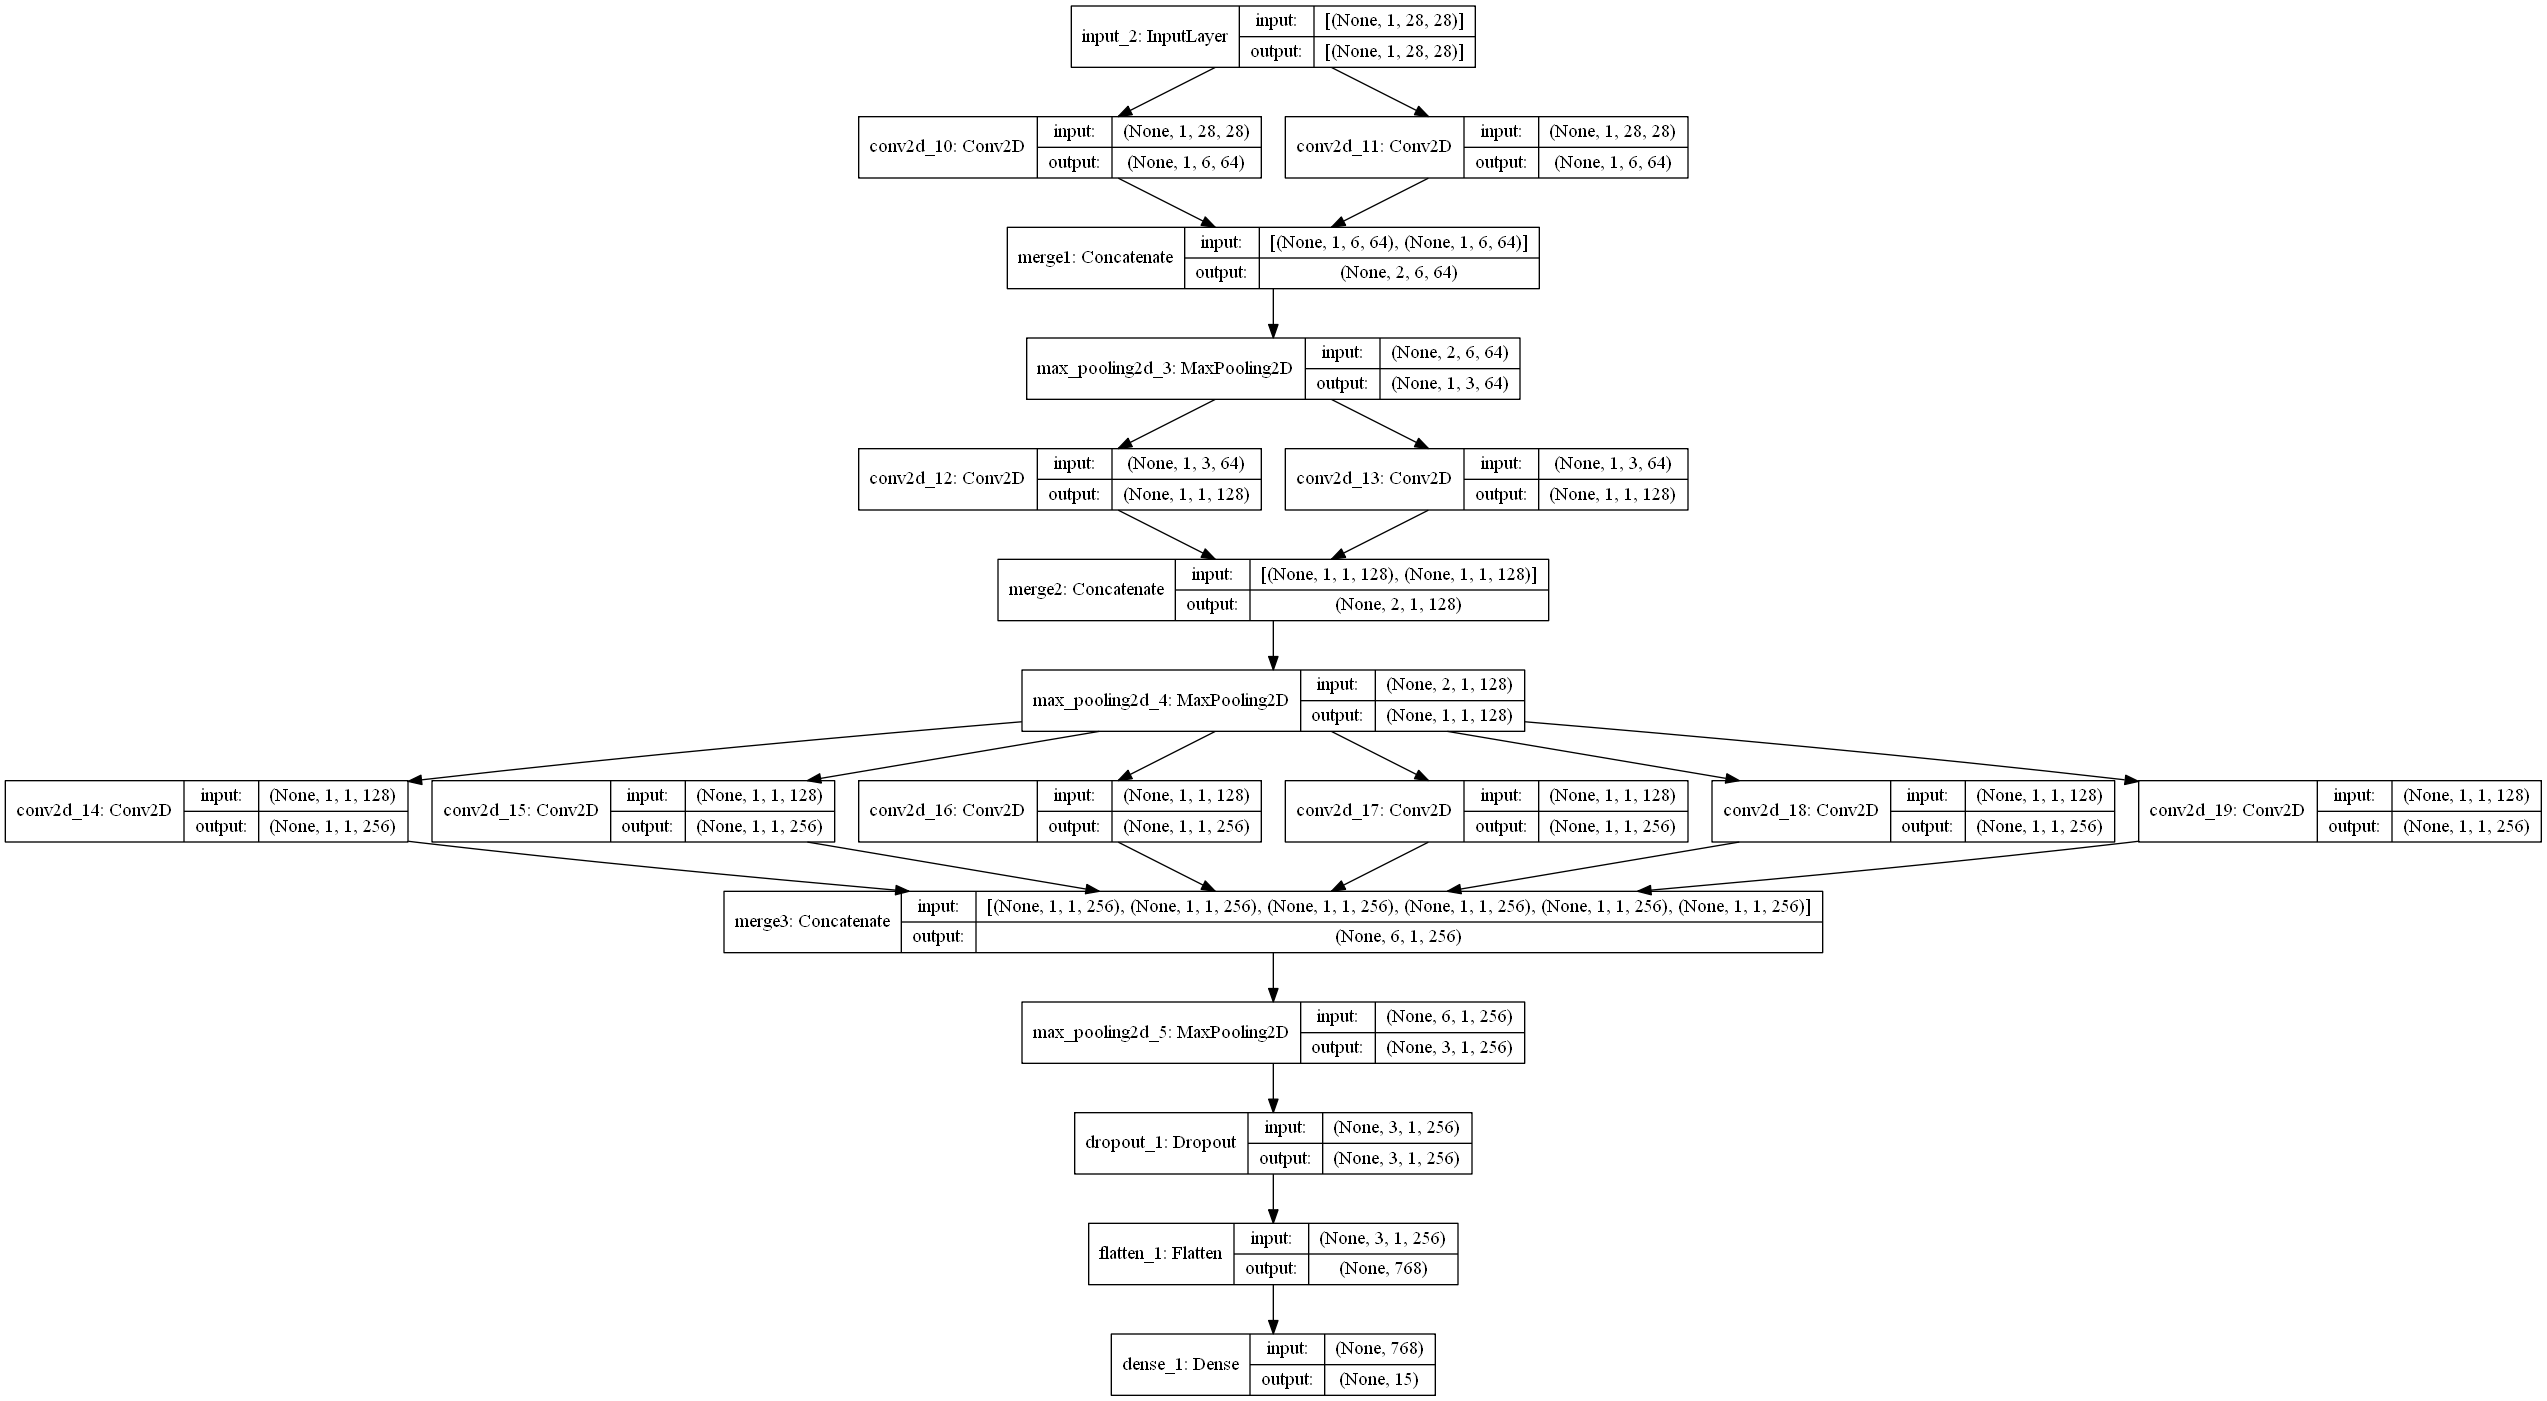

In [21]:
#loding required packges for building the neural netwrok model
from keras.layers import merge, Input, concatenate
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Convolution2D
img_rows, img_cols = 28, 28

number_filter1 = 64 # number of filters filter at convolution layer.
number_filter2 = 128 # number of filters filter at convolution layer.
number_filters3 = 256 # number of filters filter at convolution layer.
number_convolution = 3 # The dimension of the 2-D convolution filter Kernel size (3x3) and stride length of 3
number_convolution_mid = 4 # The dimension of the 2-D convolution filter Kernel size (4x4) and stride length of 4
number_convolution_init = 5 # The dimension of the 2-D convolution filter Kernel size (5x5) and stride length of 5

init = Input(shape=(1,28, 28),)

fork11 = Convolution2D(number_filter1, number_convolution_init, number_convolution_init,  activation="relu", padding='same')(init)
fork12 = Convolution2D(number_filter1, number_convolution_init, number_convolution_init, activation="relu", padding='same')(init)
merge1 = concatenate([fork11, fork12], axis=1, name='merge1')
maxpool1 = MaxPooling2D(strides=(2,2), padding='same')(merge1) # 

fork21 = Convolution2D(number_filter2, number_convolution_mid, number_convolution_mid, activation="relu", padding='same')(maxpool1)
fork22 = Convolution2D(number_filter2, number_convolution_mid, number_convolution_mid, activation="relu", padding='same')(maxpool1)
merge2 = concatenate([fork21, fork22, ], axis=1, name='merge2')
maxpool2 = MaxPooling2D(strides=(2,2), padding='same')(merge2)

fork31 = Convolution2D(number_filters3, number_convolution, number_convolution, activation="relu", padding='same')(maxpool2)
fork32 = Convolution2D(number_filters3, number_convolution, number_convolution, activation="relu", padding='same')(maxpool2)
fork33 = Convolution2D(number_filters3, number_convolution, number_convolution, activation="relu", padding='same')(maxpool2)
fork34 = Convolution2D(number_filters3, number_convolution, number_convolution, activation="relu", padding='same')(maxpool2)
fork35 = Convolution2D(number_filters3, number_convolution, number_convolution, activation="relu", padding='same')(maxpool2)
fork36 = Convolution2D(number_filters3, number_convolution, number_convolution, activation="relu", padding='same')(maxpool2)
merge3 = concatenate([fork31, fork32, fork33, fork34, fork35, fork36, ], axis=1, name='merge3')
maxpool3 = MaxPooling2D(strides=(2,2), padding='same')(merge3)

dropout = Dropout(0.5)(maxpool3)

flatten = Flatten()(dropout)
output = Dense(15, activation="softmax")(flatten)

model = Model(init,output)

model.summary()
dot_img_file = r'C:\Users\Abhishek\Desktop\final_project\Autograding-handwritten-mathematical-worksheets-master\model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [22]:
import keras
keras.backend.set_image_data_format('channels_last')

In [23]:
from keras import optimizers
ada = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
model.compile(optimizer=ada,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              validation_steps=100,
                              epochs=30)

Epoch 1/30
100/100 [==============================] - 4s 30ms/step - loss: 1.8864 - accuracy: 0.4090 - val_loss: 0.8227 - val_accuracy: 0.7225
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.7502 - accuracy: 0.7342 - val_loss: 0.5295 - val_accuracy: 0.8405
Epoch 3/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5409 - accuracy: 0.8274 - val_loss: 0.3606 - val_accuracy: 0.8940
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 0.3163 - accuracy: 0.8954 - val_loss: 0.3066 - val_accuracy: 0.8995
Epoch 5/30
100/100 [==============================] - 3s 28ms/step - loss: 0.3231 - accuracy: 0.9100 - val_loss: 0.2629 - val_accuracy: 0.9190
Epoch 6/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2791 - accuracy: 0.9040 - val_loss: 0.2424 - val_accuracy: 0.9225
Epoch 7/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2567 - accuracy: 0.9188 - val_loss: 0.2098 - val_accuracy: 0.9335

#### Validation Accuracy achieved at [10th Epoch] : ~96.55%

In [20]:
#### Saving model to use it later so that it doesn't need to be run again.
model.save('C:/Users/Abhishek/Desktop/final_project/Autograding-handwritten-mathematical-worksheets-master/models/DCNN.h5')